/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-23 14:22:10,172 - INFO - Starting 3x3 coordinate-based analysis for model: checkpoint-final
2025-07-23 14:22:10,173 - INFO - Loading model: checkpoint-final
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are 

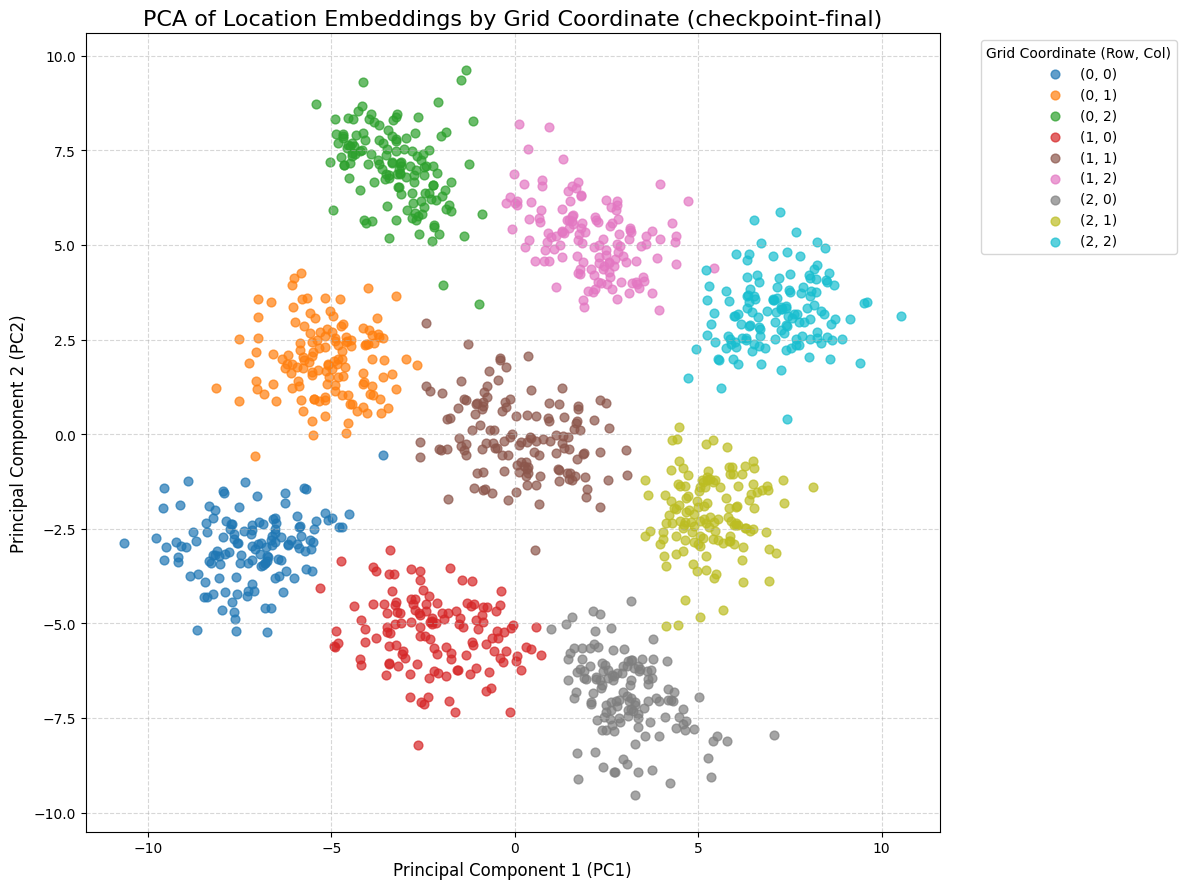

2025-07-23 14:24:15,901 - INFO - 3x3 coordinate-based analysis completed.


In [1]:
# %% [markdown]
# # Experiment: Visualizing the "Mental Map" on a 3x3 Grid
# 
# This notebook analyzes a fine-tuned GPT-2 model to investigate whether it learns a coherent spatial representation of a 3x3 grid. The central hypothesis is that if the model develops a "mental map," locations that are physically close on the grid should have similar hidden state representations.
# 
# ## Methodology
# 
# 1.  **Load a Trained Model**: We load a specific model checkpoint (`checkpoint-final`).
# 2.  **Generate 3x3 Prompts**: We create 3x3 grid environments and generate navigation prompts (both `Shortest` and `Foraging` paths).
# 3.  **Extract Hidden States**: For each location mentioned in a prompt, we extract its hidden state vector from a middle layer of the model.
# 4.  **Visualize with PCA**: We use Principal Component Analysis (PCA) to reduce the dimensionality of the embeddings. Each point in the resulting plot is colored according to its **(row, col) coordinate** on the 3x3 grid.
# 
# A successful result would show 9 distinct, colored clusters that ideally mirror the grid's topology (e.g., corners grouping together, center separate from edges).

# %%
# !pip install --upgrade torch transformers networkx scikit-learn matplotlib seaborn wonderwords umap-learn

# %%
# =============================================================================
# CELL 1: IMPORTS AND SETUP
# =============================================================================
import random
import string
import torch
import numpy as np
import networkx as nx
import logging
import os
from wonderwords import RandomWord

from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Set up logging to only show INFO level messages and higher
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Define the specific paths to your models
model_paths = {
    "gpt2-base": "gpt2",
    "checkpoint-mid": "./spatial_model/checkpoint-22355",
    "checkpoint-final": "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/all_models/generalist_v1"
}

# Instantiate the word generator
w = RandomWord()


# %%
# =============================================================================
# CELL 2: CORE GPT AND HELPER UTILITIES
# =============================================================================

class GPTWrapper:
    """Handles loading the model and tokenizer and extracting hidden states."""
    def __init__(self, model_name='gpt2'):
        logging.info(f"Loading model: {model_name}")
        path = model_paths.get(model_name, model_name)
        self.tokenizer = GPT2TokenizerFast.from_pretrained(path)
        self.model = GPT2LMHeadModel.from_pretrained(path, output_hidden_states=True)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        logging.info("Model and tokenizer loaded successfully.")

    def get_hidden_states_with_offsets(self, prompt, layer_idx):
        enc = self.tokenizer(prompt,
                             return_tensors="pt",
                             truncation=True,
                             return_offsets_mapping=True)
        with torch.no_grad():
            out = self.model(**enc)
        hidden_states = out.hidden_states[layer_idx].squeeze(0).detach().numpy()
        offsets = enc["offset_mapping"][0].tolist()
        return hidden_states, offsets

def substring_positions(haystack, needle):
    """Finds all start and end positions of a substring that is a whole word."""
    result = []
    start = 0
    while True:
        idx = haystack.find(needle, start)
        if idx == -1: break
        is_word_start = (idx == 0) or (not haystack[idx-1].isalnum())
        is_word_end = (idx + len(needle) == len(haystack)) or (not haystack[idx + len(needle)].isalnum())
        if is_word_start and is_word_end:
            result.append([idx, idx + len(needle)])
        start = idx + 1
    return result

def gather_embeddings_for_span(offsets, hidden_states, span):
    """Averages the embeddings of tokens that overlap with a given character span."""
    (start_needed, end_needed) = span
    overlap_vecs = [hidden_states[i] for i, (start_off, end_off) in enumerate(offsets) 
                  if not (end_off <= start_needed or start_off >= end_needed)]
    return np.mean(overlap_vecs, axis=0) if overlap_vecs else None


# %%
# =============================================================================
# CELL 3: UTILITIES FOR 3x3 GRID ANALYSIS
# =============================================================================

def get_grid_graph_3x3():
    """Creates a 3x3 directed grid graph with unique noun-based names."""
    nodes = set()
    while len(nodes) < 9:
        nodes.add(w.word(include_parts_of_speech=["noun"]).replace(" ", "_"))
    nodes = list(nodes)
    
    G = nx.DiGraph()
    grid_indices = np.arange(9).reshape(3, 3)
    for r in range(3):
        for c in range(3):
            current_node = nodes[grid_indices[r, c]]
            G.add_node(current_node)
            if c < 2:  # East
                neighbor = nodes[grid_indices[r, c + 1]]
                G.add_edge(current_node, neighbor, direction='R'); G.add_edge(neighbor, current_node, direction='L')
            if r < 2:  # South
                neighbor = nodes[grid_indices[r + 1, c]]
                G.add_edge(current_node, neighbor, direction='D'); G.add_edge(neighbor, current_node, direction='U')
    return G, nodes

def build_positions_3x3(node_names):
    """Maps 3x3 node names to (row, col) grid coordinates."""
    return {node_names[i]: (i // 3, i % 3) for i in range(9)}

def get_movement_options_string(G, start_node):
    """Generates the '[U D L R]' options string based on valid moves."""
    options = {"U": "NA", "D": "NA", "L": "NA", "R": "NA"}
    for _, neighbor in G.edges(start_node):
        direction = G.edges[(start_node, neighbor)]['direction']
        options[direction] = direction
    return f"[{' '.join(options.values())}]"

def generate_3x3_task_prompt(G, node_names):
    """Generates a realistic prompt for a 3x3 grid."""
    mode = random.choice(["Shortest", "Foraging"])
    mode = "Foraging"
    start_node, end_node = random.sample(node_names, 2)

    if mode == "Shortest":
        try:
            path_nodes = nx.shortest_path(G, source=start_node, target=end_node)
        except nx.NetworkXNoPath:
            return None, None
    else:  # Foraging mode
        path_nodes = [start_node]
        current_node = start_node
        for _ in range(random.randint(70, 70)): # Shorter paths for a smaller grid
            neighbors = list(G.successors(current_node))
            if not neighbors: break
            if len(path_nodes) > 1 and len(neighbors) > 1 and path_nodes[-2] in neighbors:
                neighbors.remove(path_nodes[-2])
            if not neighbors: break
            next_node = random.choice(neighbors)
            path_nodes.append(next_node)
            current_node = next_node
        end_node = path_nodes[-1]
        if start_node == end_node: return None, None

    options_str = get_movement_options_string(G, start_node)
    path_str_parts = [start_node, options_str] + [
        item for i in range(len(path_nodes) - 1) 
        for item in (G.edges[(path_nodes[i], path_nodes[i+1])]['direction'], path_nodes[i+1])
    ]
    path_as_string = " ".join(path_str_parts)
    prompt = f"MODE: {mode}, START: {start_node}, END: {end_node}, PATH: {path_as_string}"
    return prompt, path_nodes


# %%
# =============================================================================
# CELL 4: PLOTTING FUNCTION
# =============================================================================

def plot_by_coordinate(all_points, model_name_suffix, reducer="pca"):
    """
    Performs PCA/UMAP and plots the results, coloring each point by its
    (row, col) grid coordinate to visualize the model's spatial map.
    """
    if not all_points:
        logging.error("No data to plot for coordinate analysis.")
        return

    logging.info(f"Plotting {reducer.upper()} for {model_name_suffix}, colored by grid coordinate.")
    X = np.array([pt['vector'] for pt in all_points])
    
    dim_red = PCA(n_components=2, random_state=42) if reducer.lower() == "pca" else UMAP(n_components=2, random_state=42)
    X_2d = dim_red.fit_transform(X)

    plt.figure(figsize=(12, 9))
    
    coordinates = [str(p['grid_position']) for p in all_points]
    unique_coords = sorted(list(set(coordinates)), key=lambda c: eval(c))
    
    # Use a colormap that provides distinct colors, like 'tab10' for up to 10.
    cmap = plt.get_cmap("tab10", len(unique_coords))
    color_map = {coord: cmap(i) for i, coord in enumerate(unique_coords)}
    legend_title = "Grid Coordinate (Row, Col)"

    for coord_str in unique_coords:
        indices = [i for i, c in enumerate(coordinates) if c == coord_str]
        if not indices: continue
        plt.scatter(X_2d[indices, 0], X_2d[indices, 1], 
                    color=color_map.get(coord_str), alpha=0.7, s=40, label=coord_str)

    plt.title(f'PCA of Location Embeddings by Grid Coordinate ({model_name_suffix})', fontsize=16)
    plt.xlabel('Principal Component 1 (PC1)', fontsize=12)
    plt.ylabel('Principal Component 2 (PC2)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    plt.legend(title=legend_title, fontsize=10, bbox_to_anchor=(1.04, 1), loc='upper left')
    plt.tight_layout()
    
    filename = f'{model_name_suffix}_pca_colored_by_3x3_coordinate.png'
    #plt.savefig(filename, dpi=300)
    logging.info(f"Saved coordinate plot as {filename}")
    plt.show()


# %%
# =============================================================================
# CELL 5: ANALYSIS RUNNER FOR 3x3 COORDINATE PLOT
# =============================================================================

def run_3x3_coordinate_analysis(
    model_name="checkpoint-final",
    layer_idx=6,
    num_prompts=300,
    reducer="pca"
):
    """
    Runs the analysis pipeline to visualize the model's spatial map for a 3x3 grid.
    """
    logging.info(f"Starting 3x3 coordinate-based analysis for model: {model_name}")
    
    all_points = []
    wrapper = GPTWrapper(model_name)

    prompts_processed = 0
    # Collect a good number of data points
    while len(all_points) < num_prompts * 4 and prompts_processed < num_prompts * 2:
        prompts_processed += 1
        if prompts_processed % 50 == 0:
            logging.info(f"Processing 3x3 prompt #{prompts_processed}...")
            
        G, node_names = get_grid_graph_3x3()
        node_positions = build_positions_3x3(node_names)
        
        prompt_data = generate_3x3_task_prompt(G, node_names)
        if not prompt_data or prompt_data[0] is None:
            continue
        prompt, path_nodes = prompt_data
            
        hidden_states, offsets = wrapper.get_hidden_states_with_offsets(prompt, layer_idx)
        
        unique_nodes_in_path = sorted(list(set(path_nodes)), key=path_nodes.index)
        for node in unique_nodes_in_path:
            pos_list = substring_positions(prompt, node)
            vecs = [gather_embeddings_for_span(offsets, hidden_states, span) for span in pos_list]
            if not any(v is not None for v in vecs): continue

            final_vec = np.mean([v for v in vecs if v is not None], axis=0)
            
            all_points.append({
                'vector': final_vec,
                'grid_position': node_positions[node],
            })

    plot_by_coordinate(all_points, model_name, reducer=reducer)
    logging.info("3x3 coordinate-based analysis completed.")


# %%
# =============================================================================
# CELL 6: EXECUTE THE 3x3 COORDINATE ANALYSIS
# =============================================================================
if __name__ == "__main__":
    # Select the model checkpoint to analyze from the `model_paths` dictionary
    model_to_analyze = "checkpoint-final"
    
    run_3x3_coordinate_analysis(
        model_name=model_to_analyze,
        layer_idx=6,          # Middle layer of GPT-2 Small
        num_prompts=300,      # Number of prompts to generate
        reducer="pca"
    )

2025-07-23 14:24:16,110 - INFO - Starting 3x3 coordinate-based analysis for model: custom_model_final


2025-07-23 14:24:16,114 - INFO - Loading custom model and tokenizer from: /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/generalist_model/checkpoint-13000
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
2025-07-23 14:24:24,479 - INFO - Model and tokenizer loaded successfully.
2025-07-23 14:24:25,982 - INFO - Generating and processing prompt #50/500...
2025-07-23 14:24:26,706 - INFO - Generating and processing prompt #100/500...
2025-07-23 14:24:27,387 - INFO - Genera

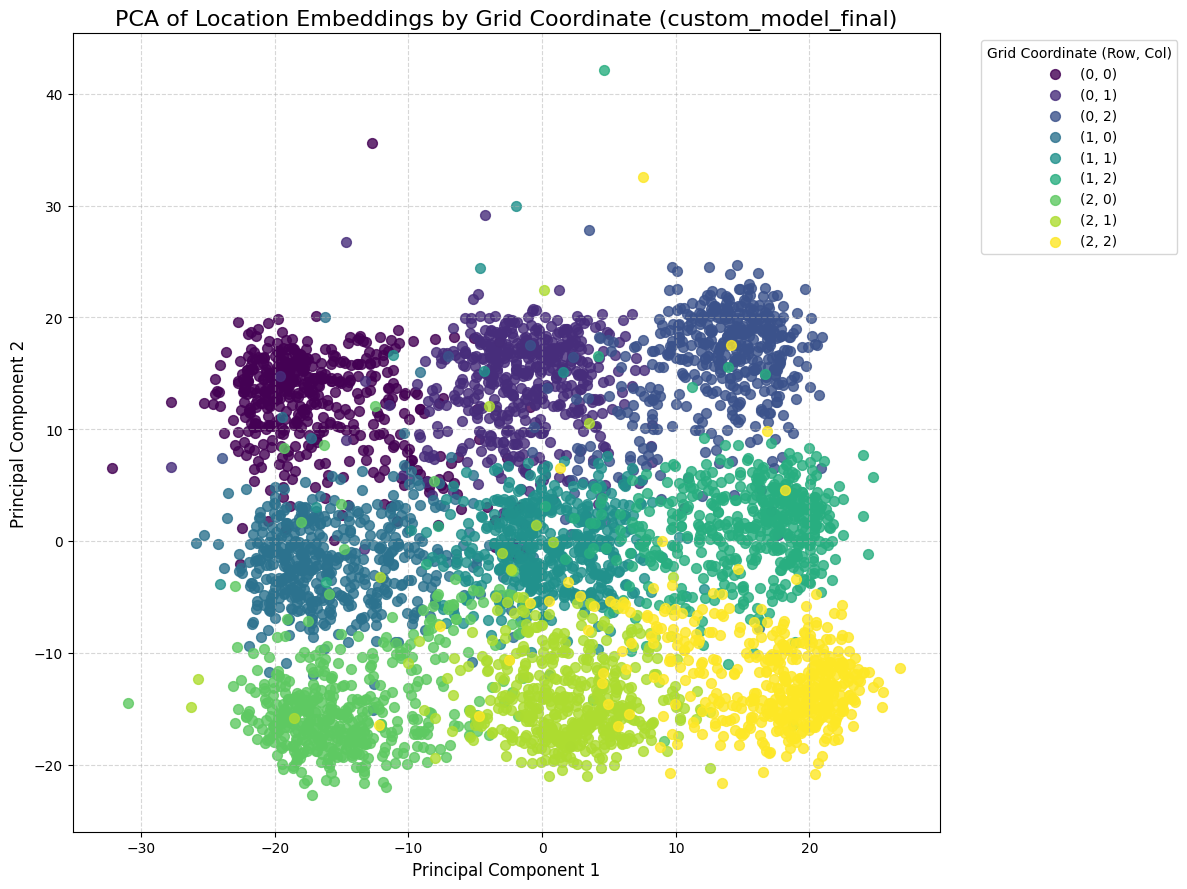

2025-07-23 14:24:33,123 - INFO - 3x3 coordinate-based analysis completed.


In [2]:
# %% [markdown]
# # Experiment: Visualizing the "Mental Map" of a Custom-Trained Model
# 
# This notebook analyzes a custom-trained GPT-style model to investigate whether it learns a coherent spatial representation of a 3x3 grid. The central hypothesis is that if the model develops a "mental map," locations that are physically close on the grid should have similar hidden state representations.
# 
# ## Methodology
# 
# 1.  **Load a Trained Model**: We load a specific model checkpoint from our custom training run.
# 2.  **Generate 3x3 Prompts**: We create 3x3 grid environments and generate navigation prompts (both `Shortest` and `Foraging` paths) in the exact format the model was trained on.
# 3.  **Extract Hidden States**: For each location mentioned in a prompt, we extract its hidden state vector from a middle layer of the model using a robust token-ID matching method.
# 4.  **Visualize with PCA**: We use Principal Component Analysis (PCA) to reduce the dimensionality of the embeddings. Each point in the resulting plot is colored according to its **(row, col) coordinate** on the 3x3 grid.
# 
# A successful result would show 9 distinct, colored clusters that ideally mirror the grid's topology.

# %%
# =============================================================================
# CELL 1: IMPORTS AND SETUP
# =============================================================================
import random
import string
import torch
import numpy as np
import networkx as nx
import logging
import os

from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def set_seed(seed):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

set_seed(42)

# --- CHANGED: Define the specific paths to your models ---
# Update this to point to the correct directory and checkpoint for your trained model
MODEL_OUTPUT_DIR = 'generalist_model' # The parent directory of your checkpoints
CHECKPOINT_NAME = 'checkpoint-13000'    # The specific checkpoint to analyze


# MODEL_OUTPUT_DIR = 'leo_model' # The parent directory of your checkpoints
# CHECKPOINT_NAME = 'checkpoint-130000'    # The specific checkpoint to analyze


model_paths = {
    "custom_model_final": os.path.join(os.getcwd(), MODEL_OUTPUT_DIR, CHECKPOINT_NAME)
}

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# %%
# =============================================================================
# CELL 2: CORE GPT AND HELPER UTILITIES (ADAPTED FOR CUSTOM MODEL)
# =============================================================================

class GPTWrapper:
    """Handles loading a custom model and tokenizer and extracting hidden states."""
    def __init__(self, model_name='custom_model_final'):
        path = model_paths.get(model_name)
        if not path or not os.path.isdir(path):
            raise FileNotFoundError(f"Model path not found or invalid: {path}. Check `model_paths`.")
            
        logging.info(f"Loading custom model and tokenizer from: {path}")
        self.tokenizer = GPT2TokenizerFast.from_pretrained(path)
        self.model = GPT2LMHeadModel.from_pretrained(path, output_hidden_states=True).to(DEVICE)
        self.model.eval()
        logging.info("Model and tokenizer loaded successfully.")

    def get_node_embeddings_from_layer(self, prompt, node_names, layer):
        """
        Extracts average embeddings for a list of node names from a specific layer
        by matching token IDs. This is the robust method.
        """
        encodings = self.tokenizer(prompt, return_tensors="pt").to(DEVICE)
        input_ids_gpu = encodings.input_ids[0]
        
        with torch.no_grad():
            outputs = self.model(**encodings)
            hidden_states_gpu = outputs.hidden_states[layer].squeeze(0)

        loc_means = {}
        for node in node_names:
            # Add a leading space to match how the tokenizer handles words in the middle of a sequence
            node_token_id = self.tokenizer.encode(' ' + node, add_special_tokens=False)
            if not node_token_id or len(node_token_id) != 1: continue # Ensure it's a single token
            node_token_id = node_token_id[0]

            # Find all positions where this node's token ID appears
            indices = (input_ids_gpu == node_token_id).nonzero(as_tuple=True)[0]
            
            if len(indices) > 0:
                # Collect all hidden states for this node and move to CPU
                node_vectors = hidden_states_gpu[indices].cpu()
                # Calculate the mean representation
                loc_means[node] = node_vectors.mean(dim=0).numpy()
                
        return loc_means

# %%
# =============================================================================
# CELL 3: UTILITIES FOR 3x3 GRID ANALYSIS (ADAPTED FOR NEW PROMPT FORMAT)
# =============================================================================

def generate_name() -> str:
    """Generates a random 2-character lowercase string for a node name."""
    return ''.join(random.choices(string.ascii_lowercase, k=2))

def get_grid_graph_3x3():
    """Creates a 3x3 directed grid graph with unique random names."""
    nodes = [generate_name() for _ in range(9)]
    G = nx.DiGraph()
    size = 3
    for r in range(size):
        for c in range(size):
            idx = r*size+c
            if c<size-1: G.add_edge(nodes[idx],nodes[idx+1],direction='EAST')
            if c>0: G.add_edge(nodes[idx],nodes[idx-1],direction='WEST')
            if r<size-1: G.add_edge(nodes[idx],nodes[idx+size],direction='SOUTH')
            if r>0: G.add_edge(nodes[idx],nodes[idx-size],direction='NORTH')
    return G, nodes

def build_positions_3x3(node_names):
    """Maps 3x3 node names to (row, col) grid coordinates."""
    return {node_names[i]: (i // 3, i % 3) for i in range(9)}

def generate_task_prompt(G, node_names):
    """Generates a realistic prompt in the format the custom model was trained on."""
    mode = random.choice(["Shortest", "Foraging"])
    mode = "Foraging"
    start_node, end_node = random.sample(node_names, 2)

    if mode == "Shortest":
        try:
            path_nodes = nx.shortest_path(G, source=start_node, target=end_node)
            if len(path_nodes) < 4: return None, None # Enforce min length
            header = f"MODE Shortest START {start_node} END {end_node} PATH "
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            return None, None
    else:  # Foraging mode
        path_nodes = [start_node]
        current_node = start_node
        for _ in range(50 - 1): # Fixed long length
            neighbors = list(G.successors(current_node))
            if not neighbors: break
            next_node = random.choice(neighbors)
            path_nodes.append(next_node)
            current_node = next_node
        header = f"MODE Foraging START {start_node} PATH "

    path_body = ""
    for i in range(len(path_nodes) - 1):
        n1, n2 = path_nodes[i], path_nodes[i+1]
        try:
            direction = G.edges[(n1, n2)]['direction']
            path_body += f"{n1} {direction} "
        except KeyError: return None, None
    path_body += path_nodes[-1]
    
    prompt = header + path_body
    return prompt, path_nodes

# %%
# =============================================================================
# CELL 4: PLOTTING FUNCTION (Unchanged)
# =============================================================================
def plot_by_coordinate(all_points, model_name_suffix, reducer="pca"):
    if not all_points:
        logging.error("No data to plot for coordinate analysis."); return
    logging.info(f"Plotting {reducer.upper()} for {model_name_suffix}, colored by grid coordinate.")
    
    X = np.array([pt['vector'] for pt in all_points])
    dim_red = PCA(n_components=2, random_state=42)
    X_2d = dim_red.fit_transform(X)

    plt.figure(figsize=(12, 9))
    coordinates = [str(p['grid_position']) for p in all_points]
    unique_coords = sorted(list(set(coordinates)), key=lambda c: eval(c))
    cmap = plt.get_cmap("viridis", len(unique_coords))
    color_map = {coord: cmap(i) for i, coord in enumerate(unique_coords)}
    
    for coord_str in unique_coords:
        indices = [i for i, c in enumerate(coordinates) if c == coord_str]
        if not indices: continue
        plt.scatter(X_2d[indices, 0], X_2d[indices, 1], 
                    color=color_map.get(coord_str), alpha=0.8, s=50, label=coord_str)

    plt.title(f'PCA of Location Embeddings by Grid Coordinate ({model_name_suffix})', fontsize=16)
    plt.xlabel('Principal Component 1', fontsize=12); plt.ylabel('Principal Component 2', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title="Grid Coordinate (Row, Col)", bbox_to_anchor=(1.04, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# %%
# =============================================================================
# CELL 5: ANALYSIS RUNNER (Simplified)
# =============================================================================

def run_3x3_coordinate_analysis(model_name="custom_model_final", layer_idx=6, num_prompts=300):
    logging.info(f"Starting 3x3 coordinate-based analysis for model: {model_name}")
    
    all_points = []
    wrapper = GPTWrapper(model_name)

    for i in range(num_prompts):
        if (i + 1) % 50 == 0:
            logging.info(f"Generating and processing prompt #{i+1}/{num_prompts}...")
            
        G, node_names = get_grid_graph_3x3()
        node_positions = build_positions_3x3(node_names)
        
        prompt_data = generate_task_prompt(G, node_names)
        if not prompt_data or prompt_data[0] is None:
            continue
        prompt, path_nodes = prompt_data
            
        # Extract embeddings for all unique nodes in the path
        unique_nodes_in_path = sorted(list(set(path_nodes)), key=path_nodes.index)
        node_embeddings = wrapper.get_node_embeddings_from_layer(prompt, unique_nodes_in_path, layer_idx)
        
        for node, vec in node_embeddings.items():
            all_points.append({'vector': vec, 'grid_position': node_positions[node]})

    plot_by_coordinate(all_points, model_name)
    logging.info("3x3 coordinate-based analysis completed.")

# %%
# =============================================================================
# CELL 6: EXECUTE THE 3x3 COORDINATE ANALYSIS
# =============================================================================
if __name__ == "__main__":
    # Select the model checkpoint to analyze from the `model_paths` dictionary
    model_to_analyze = "custom_model_final"
    
    run_3x3_coordinate_analysis(
        model_name=model_to_analyze,
        layer_idx=6,          # Middle layer of GPT-2
        num_prompts=500       # More prompts for a denser plot
    )

In [3]:
# --- Define the paths to your models ---
# MODEL_OUTPUT_DIR = 'generalist_model' # The parent directory of your checkpoints
# CHECKPOINT_NAME = 'checkpoint-13000'    # The specific checkpoint to analyze


MODEL_OUTPUT_DIR = 'all_models' # The parent directory of your checkpoints
CHECKPOINT_NAME = 'generalist_v2'    # The specific checkpoint to analyze


model_paths = {
    "custom_model_final": os.path.join(os.getcwd(), MODEL_OUTPUT_DIR, CHECKPOINT_NAME)
}

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model_paths = {
    "custom_model_final": MODEL_OUTPUT_DIR
}




2025-07-23 14:24:33,203 - INFO - Starting 'Primed Map' analysis for model: generalist_model/checkpoint-13000
2025-07-23 14:24:33,206 - INFO - Loading custom model and tokenizer from: generalist_model/checkpoint-13000
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


2025-07-23 14:24:34,442 - INFO - Generating and processing primed prompt #50/1000...
2025-07-23 14:24:34,880 - INFO - Generating and processing primed prompt #100/1000...
2025-07-23 14:24:35,306 - INFO - Generating and processing primed prompt #150/1000...
2025-07-23 14:24:35,639 - INFO - Generating and processing primed prompt #200/1000...
2025-07-23 14:24:36,022 - INFO - Generating and processing primed prompt #250/1000...
2025-07-23 14:24:36,406 - INFO - Generating and processing primed prompt #300/1000...
2025-07-23 14:24:36,697 - INFO - Generating and processing primed prompt #350/1000...
2025-07-23 14:24:37,038 - INFO - Generating and processing primed prompt #400/1000...
2025-07-23 14:24:37,446 - INFO - Generating and processing primed prompt #450/1000...
2025-07-23 14:24:37,882 - INFO - Generating and processing primed prompt #500/1000...
2025-07-23 14:24:38,343 - INFO - Generating and processing primed prompt #550/1000...
2025-07-23 14:24:38,765 - INFO - Generating and process

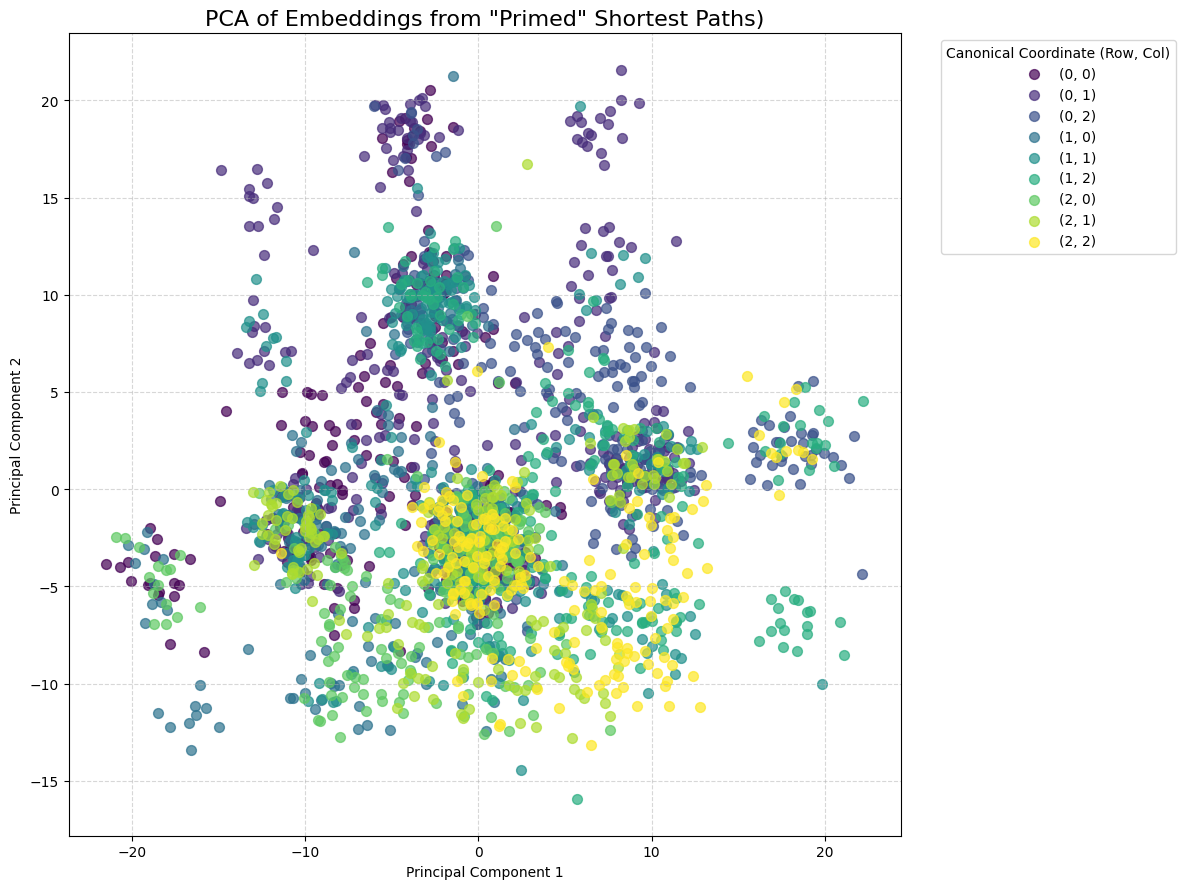

2025-07-23 14:24:43,680 - INFO - Primed map analysis completed.


In [4]:
# %% [markdown]
# # Experiment: Visualizing the "Mental Map" from a Primed Context
# 
# This notebook analyzes a custom-trained model to visualize its spatial map. To ensure the model has sufficient information, we use a "primed map" methodology.
# 
# ## Methodology
# 
# 1.  **Load a Trained Model**: We load a specific model checkpoint.
# 2.  **Generate Primed Prompts**: We create a two-part prompt. The first part ("CONTEXT") is a long random walk to give the model a full view of the grid. The second part ("TASK") is a specific `ShortestPath` problem within that grid.
# 3.  **Extract Hidden States**: For each location mentioned *only in the TASK part* of the prompt, we extract its hidden state vector.
# 4.  **Visualize with PCA**: We use PCA on all collected embeddings. Each point in the resulting plot is colored according to its **(row, col) coordinate**, showing the model's representation of locations while in a "planning" mindset.

# %%
# =============================================================================
# CELL 1: IMPORTS AND SETUP
# =============================================================================
import random
import string
import torch
import numpy as np
import networkx as nx
import logging
import os
from collections import defaultdict

from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def set_seed(seed):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
set_seed(42)



DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LAYER_IDX = 6
PRIMING_WALK_LENGTH = 70 
N_PROMPTS = 1000         

# %%
# =============================================================================
# CELL 2: CORE GPT AND HELPER UTILITIES
# =============================================================================

class GPTWrapper:
    def __init__(self, model_path):
        if not os.path.isdir(model_path): raise FileNotFoundError(f"Model path not found: {model_path}")
        logging.info(f"Loading custom model and tokenizer from: {model_path}")
        self.tokenizer = GPT2TokenizerFast.from_pretrained(model_path)
        self.model = GPT2LMHeadModel.from_pretrained(model_path, output_hidden_states=True).to(DEVICE)
        self.model.eval()

    def get_node_embeddings_from_task_part(self, prompt, context_str, node_names, layer):
        context_token_ids = self.tokenizer.encode(context_str)
        task_start_token_idx = len(context_token_ids)
        encodings = self.tokenizer(prompt, return_tensors="pt").to(DEVICE)
        input_ids_gpu = encodings.input_ids[0]
        with torch.no_grad():
            outputs = self.model(**encodings)
            hidden_states_gpu = outputs.hidden_states[layer].squeeze(0)
        loc_means = {}
        for node in node_names:
            node_token_id = self.tokenizer.encode(' ' + node, add_special_tokens=False)
            if not node_token_id or len(node_token_id) != 1: continue
            node_token_id = node_token_id[0]
            all_indices = (input_ids_gpu == node_token_id).nonzero(as_tuple=True)[0]
            task_indices = all_indices[all_indices >= task_start_token_idx]
            if len(task_indices) > 0:
                node_vectors = hidden_states_gpu[task_indices].cpu()
                loc_means[node] = node_vectors.mean(dim=0).numpy()
        return loc_means

# %%
# =============================================================================
# CELL 3: UTILITIES FOR 3x3 GRID ANALYSIS (WITH CORRECTED PRIMING LOGIC)
# =============================================================================

def generate_name()->str: return ''.join(random.choices(string.ascii_lowercase,k=2))
def get_grid_graph_3x3():
    nodes=[generate_name() for _ in range(9)]; G=nx.DiGraph(); size=3
    for r in range(size):
        for c in range(size):
            idx=r*size+c
            if c<size-1: G.add_edge(nodes[idx],nodes[idx+1],direction='EAST')
            if c>0: G.add_edge(nodes[idx],nodes[idx-1],direction='WEST')
            if r<size-1: G.add_edge(nodes[idx],nodes[idx+size],direction='SOUTH')
            if r>0: G.add_edge(nodes[idx],nodes[idx-size],direction='NORTH')
    return G, nodes
def build_positions_3x3(node_names): return {node_names[i]:(i//3,i%3) for i in range(9)}

def generate_long_random_walk(G, start_node, walk_length):
    """Generates a single random walk with revisits from a given start node."""
    walk = [start_node]
    current_node = start_node
    for _ in range(walk_length - 1):
        neighbors = list(G.successors(current_node))
        if not neighbors: break
        next_node = random.choice(neighbors)
        walk.append(next_node)
        current_node = next_node
    return walk

def walk_to_string(walk, G):
    """Converts a list of nodes into a path string."""
    path_body = ""
    for i in range(len(walk) - 1):
        n1, n2 = walk[i], walk[i+1]
        try:
            direction = G.edges[(n1, n2)]['direction']
            path_body += f"{n1} {direction} "
        except KeyError: return "" # Invalid step
    path_body += walk[-1]
    return path_body

# --- THE CORRECTED PROMPT GENERATION FUNCTION ---
def generate_primed_task_prompt(G, node_names, priming_walk_length=50):
    """
    Generates a two-part prompt using the robust foraging logic for priming.
    """
    # 1. Create the priming context using the same logic as a "Foraging" path
    priming_start_node = random.choice(node_names)
    priming_walk = generate_long_random_walk(G, priming_start_node, priming_walk_length)
    priming_walk_str = walk_to_string(priming_walk, G)
    if not priming_walk_str: return None, None, None
    context_str = f"MODE Foraging PATH {priming_walk_str} "

    # 2. Create the shortest path task
    start_node, end_node = random.sample(node_names, 2)
    try:
        path_nodes = nx.shortest_path(G, source=start_node, target=end_node)
        if len(path_nodes) < 3: return None, None, None # Ignore trivial paths
    except nx.NetworkXNoPath:
        return None, None, None
        
    task_header = f"MODE Shortest START {start_node} END {end_node} PATH "
    task_body = walk_to_string(path_nodes, G)
    task_str = task_header + task_body

    # 3. Combine and return
    full_prompt = context_str + task_str
    return full_prompt, context_str, path_nodes

# %%
# =============================================================================
# CELL 4: PLOTTING FUNCTION (Unchanged)
# =============================================================================
def plot_by_coordinate(all_points, model_name_suffix):
    if not all_points: logging.error("No data to plot."); return
    logging.info(f"Plotting PCA for {model_name_suffix}, colored by grid coordinate.")
    
    X = np.array([pt['vector'] for pt in all_points])
    pca = PCA(n_components=2, random_state=42)
    X_2d = pca.fit_transform(X)

    plt.figure(figsize=(12, 9))
    coordinates = [str(p['grid_position']) for p in all_points]
    unique_coords = sorted(list(set(coordinates)), key=lambda c: eval(c))
    cmap = plt.get_cmap("viridis", len(unique_coords))
    color_map = {coord: cmap(i) for i, coord in enumerate(unique_coords)}
    
    for coord_str in unique_coords:
        indices = [i for i, c in enumerate(coordinates) if c == coord_str]
        if not indices: continue
        plt.scatter(X_2d[indices, 0], X_2d[indices, 1], 
                    color=color_map.get(coord_str), alpha=0.7, s=50, label=coord_str)

    plt.title(f'PCA of Embeddings from "Primed" Shortest Paths)', fontsize=16)
    plt.xlabel('Principal Component 1'); plt.ylabel('Principal Component 2')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title="Canonical Coordinate (Row, Col)", bbox_to_anchor=(1.04, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# %%
# =============================================================================
# CELL 5: ANALYSIS RUNNER
# =============================================================================
def run_3x3_primed_analysis(model_path, layer_idx=6, num_prompts=300):
    model_name = os.path.basename(os.path.dirname(model_path)) + "/" + os.path.basename(model_path)
    logging.info(f"Starting 'Primed Map' analysis for model: {model_name}")
    
    wrapper = GPTWrapper(model_path)
    all_points = []

    for i in range(num_prompts):
        if (i + 1) % 50 == 0:
            logging.info(f"Generating and processing primed prompt #{i+1}/{num_prompts}...")
            
        G, node_names = get_grid_graph_3x3()
        node_positions = build_positions_3x3(node_names)
        
        prompt_data = generate_primed_task_prompt(G, node_names, priming_walk_length=PRIMING_WALK_LENGTH)
        if not prompt_data or prompt_data[0] is None: continue
        full_prompt, context_str, task_path_nodes = prompt_data
            
        unique_nodes_in_task = sorted(list(set(task_path_nodes)), key=task_path_nodes.index)
        node_embeddings = wrapper.get_node_embeddings_from_task_part(full_prompt, context_str, unique_nodes_in_task, layer_idx)
        
        for node, vec in node_embeddings.items():
            all_points.append({'vector': vec, 'grid_position': node_positions[node]})

    plot_by_coordinate(all_points, model_name)
    logging.info("Primed map analysis completed.")

# %%
# =============================================================================
# CELL 6: EXECUTE THE ANALYSIS
# =============================================================================
if __name__ == "__main__":
    run_3x3_primed_analysis(
        model_path="generalist_model/checkpoint-13000",  # Update this to your model path
        layer_idx=LAYER_IDX,
        num_prompts=N_PROMPTS
    )

2025-07-23 14:24:43,747 - INFO - Starting 3x3 grid analysis for model: custom_model_final
2025-07-23 14:24:43,748 - INFO - Loading custom model and tokenizer from: /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/all_models/generalist_v2
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
2025-07-23 14:24:54,928 - INFO - Processing prompt 100/1000...
2025-07-23 14:24:56,026 - INFO - Processing prompt 200/1000...
2025-07-23 14:24:57,353 - INFO - Processing prompt 300/1000...
2025-07-23 14:24:58,480 - INFO - Processing prompt 400/1000...
2025-07-23 14:24:59,596 - INFO - Processing prompt 500/1000...
2025-07-23 14:25:01,050 - INFO - Processing prompt 600/1000...
2025-07-23 14:25:02,371 - INFO - Processing prompt 700/1000...
2025-07-23 14:25:03,637 - INFO - Processing prompt 800/1000...
2025-07-23 14:25:04,809 - INFO - Processing prompt 900/1000...
2025-07-23 14:25:06,043 - INFO - Processing prompt 1000/1000...
2025-07-23 14:25:06,055 - INFO - Plotting PCA for custom_model_final, colored by 't

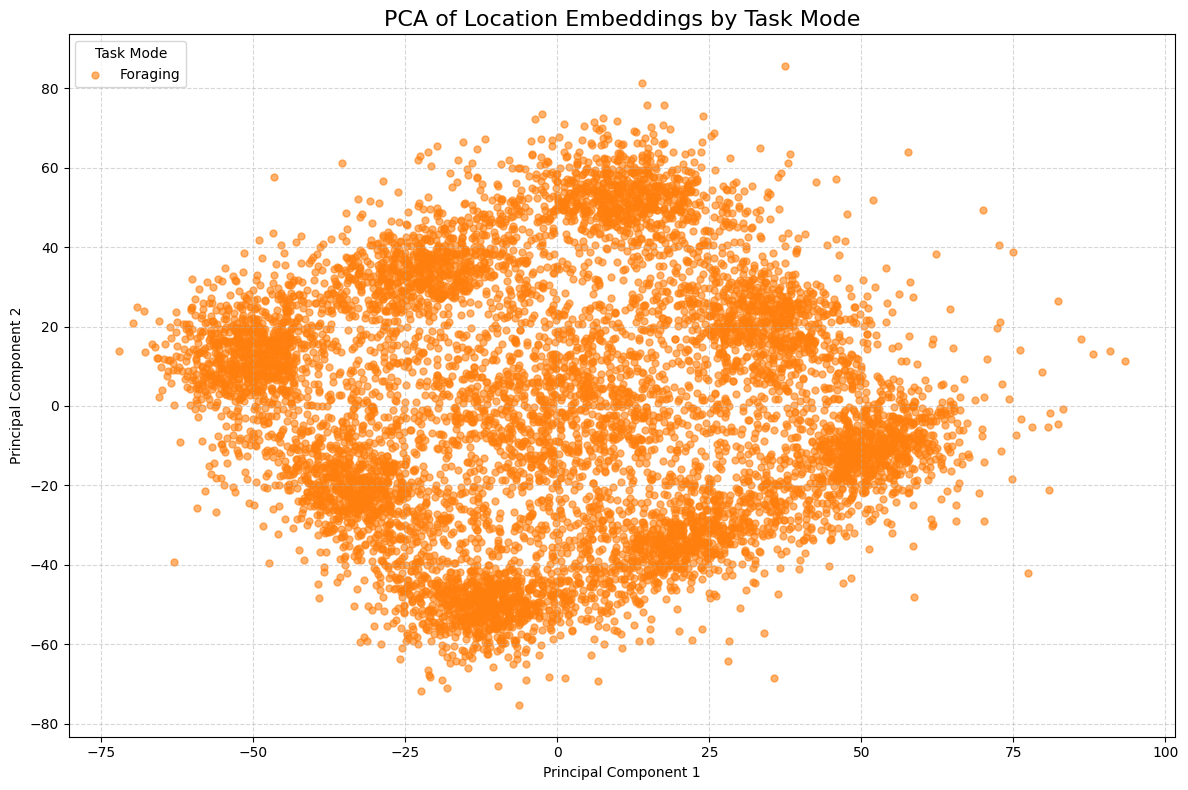

2025-07-23 14:25:24,221 - INFO - Plotting PCA for custom_model_final, colored by 'positional_role'.


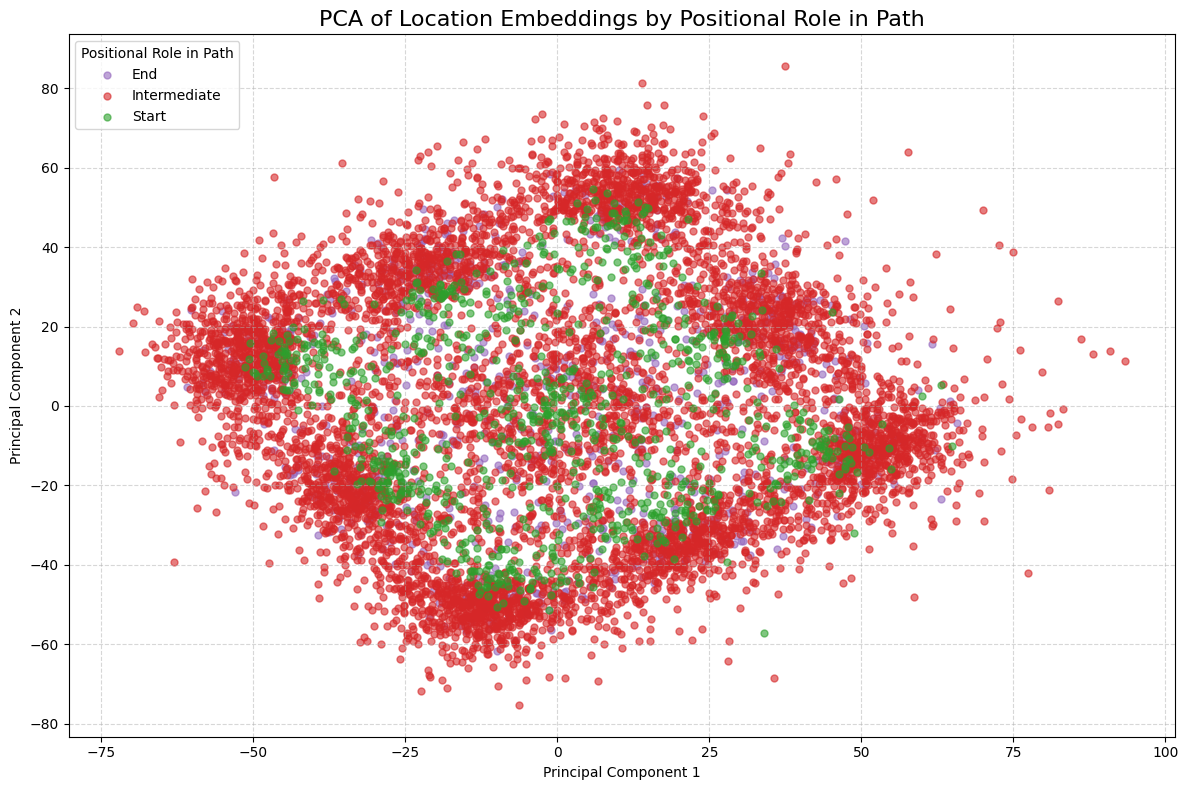

2025-07-23 14:25:42,772 - INFO - Plotting PCA for custom_model_final, colored by 'topological_role'.


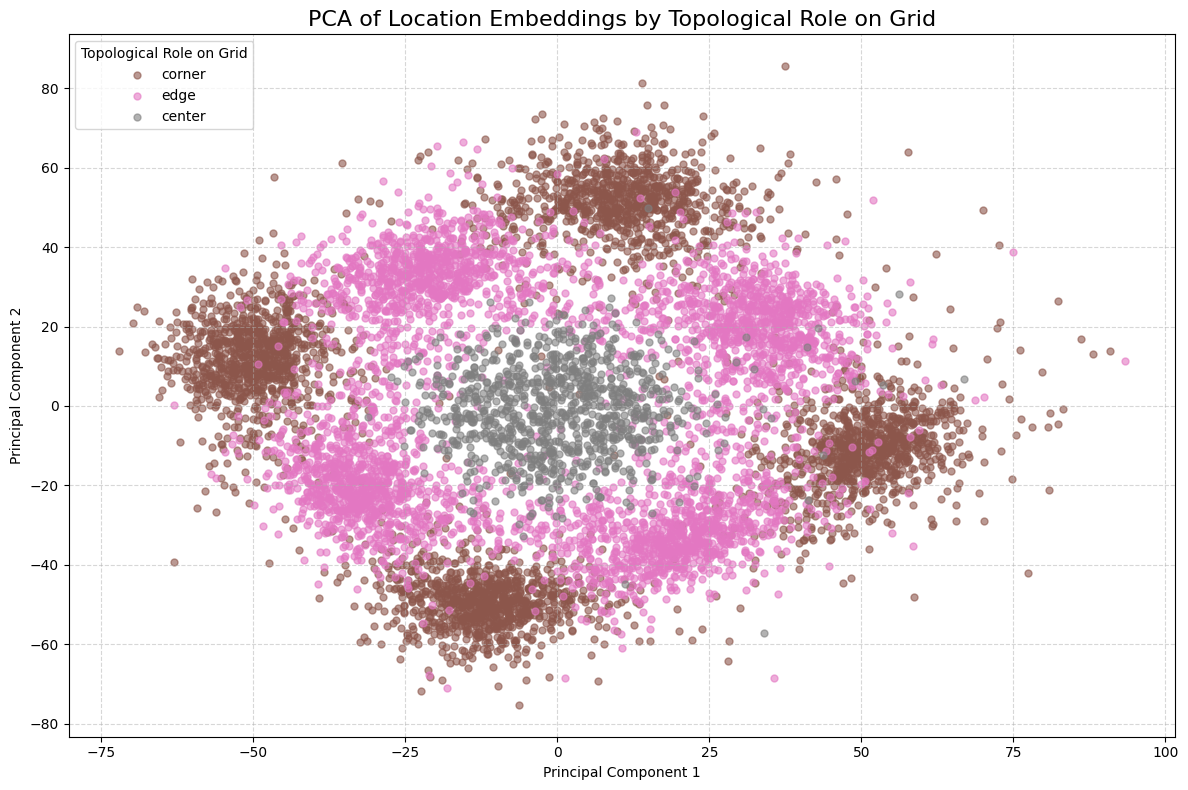

2025-07-23 14:26:05,016 - INFO - 3x3 analysis completed.


In [5]:
# %% [markdown]
# # Experiment: Analyzing Task and Spatial Representations in a Custom 3x3 Model
# 
# This notebook analyzes a custom GPT model trained on spatial navigation tasks in 3x3 grid environments. The goal is to understand what kind of representations the model learns about the environment and the tasks it performs.
# 
# ## Methodology
# 
# 1.  **Load a Trained Model**: We load a specific model checkpoint from our custom training run.
# 2.  **Generate Realistic Prompts**: We create new 3x3 grid environments and generate prompts that precisely match the format the model was trained on.
# 3.  **Extract Hidden States**: For each location mentioned, we extract its hidden state vector from a middle layer using a robust token-ID matching method.
# 4.  **Categorize Embeddings**: We tag each embedding with metadata: Task Mode, Positional Role, and Topological Role.
# 5.  **Visualize with PCA**: We use PCA to visualize how the model organizes its internal representations based on these categories.

# %%
# =============================================================================
# CELL 1: IMPORTS AND SETUP
# =============================================================================
import random
import string
import torch
import numpy as np
import networkx as nx
import logging
import os

from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def set_seed(seed):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
set_seed(42)

# Define the paths to your trained models.
MODEL_OUTPUT_DIR = 'all_models' # The parent directory of your checkpoints
CHECKPOINT_NAME = 'generalist_v2'    # The specific checkpoint to analyze


model_paths = {
    "custom_model_final": os.path.join(os.getcwd(), MODEL_OUTPUT_DIR, CHECKPOINT_NAME)
}

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# %%
# =============================================================================
# CELL 2: CORE GPT AND HELPER UTILITIES (ADAPTED FOR CUSTOM MODEL)
# =============================================================================

class GPTWrapper:
    """Handles loading a custom model and tokenizer and extracting hidden states."""
    def __init__(self, model_name='custom_model_final'):
        path = model_paths.get(model_name)
        if not path or not os.path.isdir(path):
            raise FileNotFoundError(f"Model path not found: {path}. Check `model_paths`.")
        logging.info(f"Loading custom model and tokenizer from: {path}")
        self.tokenizer = GPT2TokenizerFast.from_pretrained(path)
        self.model = GPT2LMHeadModel.from_pretrained(path, output_hidden_states=True).to(DEVICE)
        self.model.eval()

    def get_node_embeddings_from_layer(self, prompt, node_names, layer):
        """Extracts average embeddings for nodes by matching token IDs."""
        encodings = self.tokenizer(prompt, return_tensors="pt").to(DEVICE)
        input_ids_gpu = encodings.input_ids[0]
        with torch.no_grad():
            outputs = self.model(**encodings)
            hidden_states_gpu = outputs.hidden_states[layer].squeeze(0)
        loc_means = {}
        for node in node_names:
            node_token_id = self.tokenizer.encode(' ' + node, add_special_tokens=False)
            if not node_token_id or len(node_token_id) != 1: continue
            node_token_id = node_token_id[0]
            indices = (input_ids_gpu == node_token_id).nonzero(as_tuple=True)[0]
            if len(indices) > 0:
                node_vectors = hidden_states_gpu[indices].cpu()
                loc_means[node] = node_vectors.mean(dim=0).numpy()
        return loc_means

# %%
# =============================================================================
# CELL 3: UTILITIES FOR 3x3 GRID ANALYSIS
# =============================================================================

def generate_name()->str: return ''.join(random.choices(string.ascii_lowercase,k=2))

def get_grid_graph_3x3():
    nodes=[generate_name() for _ in range(9)]; G=nx.DiGraph(); size=3
    for r in range(size):
        for c in range(size):
            idx=r*size+c
            if c<size-1: G.add_edge(nodes[idx],nodes[idx+1],direction='EAST')
            if c>0: G.add_edge(nodes[idx],nodes[idx-1],direction='WEST')
            if r<size-1: G.add_edge(nodes[idx],nodes[idx+size],direction='SOUTH')
            if r>0: G.add_edge(nodes[idx],nodes[idx-size],direction='NORTH')
    return G, nodes

def build_positions_3x3(node_names):
    return {node_names[i]: (i // 3, i % 3) for i in range(9)}

def get_topological_role_3x3(position):
    """Determines the topological role (corner, edge, center) for a 3x3 grid."""
    r, c = position
    if r in {0, 2} and c in {0, 2}: return 'corner'
    if r in {0, 2} or c in {0, 2}: return 'edge'
    return 'center'

def generate_3x3_task_prompt(G, node_names):
    """Generates a realistic prompt for a 3x3 grid, matching the custom training format."""
    #mode = random.choice(["Shortest", "Foraging"])
    mode = random.choice(["Foraging"])
    #mode = random.choice(["Shortest"])
    start_node, end_node = random.sample(node_names, 2)

    if mode == "Shortest":
        try:
            path_nodes = nx.shortest_path(G, source=start_node, target=end_node)
            if len(path_nodes) < 3: return None, None, None # Enforce min length
            header = f"MODE Shortest START {start_node} END {end_node} PATH "
        except nx.NetworkXNoPath:
            return None, None, None
    else:  # Foraging mode
        path_nodes = [start_node]
        current_node = start_node
        for _ in range(50 - 1): # Fixed long length
            neighbors = list(G.successors(current_node))
            if not neighbors: break
            next_node = random.choice(neighbors)
            path_nodes.append(next_node)
            current_node = next_node
        header = f"MODE Foraging START {start_node} PATH "

    path_body = ""
    for i in range(len(path_nodes) - 1):
        n1, n2 = path_nodes[i], path_nodes[i+1]
        try:
            direction = G.edges[(n1, n2)]['direction']
            path_body += f"{n1} {direction} "
        except KeyError: return None, None, None
    path_body += path_nodes[-1]
    
    #prompt = header + path_body
    prompt = path_body
    return prompt, path_nodes, mode

# %%
# =============================================================================
# CELL 4: PLOTTING FUNCTION
# =============================================================================

def plot_by_property(all_points, model_name, reducer="pca", color_by='task_mode'):
    if not all_points: logging.error(f"No data to plot for property '{color_by}'."); return

    logging.info(f"Plotting {reducer.upper()} for {model_name}, colored by '{color_by}'.")
    X = np.array([pt['vector'] for pt in all_points])
    
    dim_red = PCA(n_components=2, random_state=42)
    X_2d = dim_red.fit_transform(X)

    plt.figure(figsize=(12, 8))
    
    groups = sorted(list(set(pt[color_by] for pt in all_points)))
    color_maps = {
        'task_mode': ({'Shortest': '#1f77b4', 'Foraging': '#ff7f0e'}, "Task Mode"),
        'positional_role': ({'Start': '#2ca02c', 'Intermediate': '#d62728', 'End': '#9467bd'}, "Positional Role in Path"),
        'topological_role': ({'corner': '#8c564b', 'edge': '#e377c2', 'center': '#7f7f7f'}, "Topological Role on Grid")
    }
    color_map, legend_title = color_maps.get(color_by)
    if color_by == 'topological_role': groups = ['corner', 'edge', 'center']

    for group in groups:
        group_indices = [i for i, p in enumerate(all_points) if p.get(color_by) == group]
        if not group_indices: continue
        plt.scatter(X_2d[group_indices, 0], X_2d[group_indices, 1], 
                    color=color_map.get(group), alpha=0.6, s=25, label=str(group))

    plt.title(f'PCA of Location Embeddings by {legend_title}', fontsize=16)
    plt.xlabel('Principal Component 1'); plt.ylabel('Principal Component 2')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title=legend_title, loc='upper left')
    plt.tight_layout()
    plt.show()

# %%
# =============================================================================
# CELL 5: MAIN ANALYSIS FUNCTION
# =============================================================================

def run_3x3_analysis(model_name="custom_model_final", layer_idx=6, num_prompts=1000):
    logging.info(f"Starting 3x3 grid analysis for model: {model_name}")
    
    all_points = []
    wrapper = GPTWrapper(model_name)

    for i in range(num_prompts):
        if (i + 1) % 100 == 0:
            logging.info(f"Processing prompt {i+1}/{num_prompts}...")
            
        G, node_names = get_grid_graph_3x3()
        node_positions = build_positions_3x3(node_names)
        
        prompt_data = generate_3x3_task_prompt(G, node_names)
        if not prompt_data or prompt_data[0] is None: continue
        prompt, path_nodes, mode = prompt_data
            
        unique_nodes_in_path = sorted(list(set(path_nodes)), key=path_nodes.index)
        node_embeddings = wrapper.get_node_embeddings_from_layer(prompt, unique_nodes_in_path, layer_idx)
        
        for node, vec in node_embeddings.items():
            positional_role = 'Start' if node == path_nodes[0] else 'End' if node == path_nodes[-1] else 'Intermediate'
            grid_pos = node_positions[node]
            
            all_points.append({
                'vector': vec,
                'task_mode': mode,
                'positional_role': positional_role,
                'topological_role': get_topological_role_3x3(grid_pos),
            })

    if not all_points:
        logging.error("Failed to gather any data points. Aborting plots."); return
        
    plot_by_property(all_points, model_name, color_by='task_mode')
    plot_by_property(all_points, model_name, color_by='positional_role')
    plot_by_property(all_points, model_name, color_by='topological_role')
    
    logging.info("3x3 analysis completed.")

# %%
# =============================================================================
# CELL 6: EXECUTE THE ANALYSIS
# =============================================================================
if __name__ == "__main__":
    model_to_analyze = "custom_model_final"
    
    run_3x3_analysis(
        model_name=model_to_analyze,
        layer_idx=6,
        num_prompts=1000
    )